In [1]:
#default_exp seutao

In [2]:
#export
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [3]:
#export
path = Path('~/kaggle/RSNA2019_1st_place_solution/SequenceModel/features/stage2_finetune/st_se101_256_fine').expanduser()
np_file = path/'st_se101_256_fine_val_oof_feature_TTA_stage2_finetune.npy'
np_file_test = path/'st_se101_256_fine_test_feature_TTA_stage2_finetune.npy'
csv_file = path/'st_se101_256_fine_val_prob_TTA_stage2_finetune.csv'
csv_file_test = path/'st_se101_256_fine_test_prob_TTA_stage2_finetune.csv'


fth_file = csv_file.with_suffix('.fth')
fth_file_test = csv_file_test.with_suffix('.fth')

In [4]:
# preprocessing
# pd.read_csv(csv_file).to_feather(fth_file)
# pd.read_csv(csv_file_test).to_feather(fth_file_test)

In [5]:
#export
class OpenFeatMap:
    def __init__(self, feature_map):
        self.fm = feature_map
        self.tt = ToTensor()
    def __call__(self, item):
        if isinstance(item, (str, Path)): return self.fn(item)
        xs = [torch.from_numpy(self.fm[x]) for x in item]
        return TensorCTScan(torch.stack(xs))

## dsets

In [6]:
# features = np.load(str(np_file))

In [7]:
#export
def get_seutao_dls(df, np_file, csv_file, bs=1, num_workers=8, test=False):
    print('loading features')
    features = np.load(str(np_file))
    prob_df = pd.read_csv(csv_file)
    sops = [f.replace('.dcm', '') for f in prob_df.filename.values]
    feature_map = dict(zip(sops, features))
    print('Done loading features')

    dsets = get_3d_dsets(df, open_fn=OpenFeatMap(feature_map), test=test)
    return get_dls(dsets, bs, None, num_workers)


In [8]:
dls = get_seutao_dls(Meta.df_comb1, np_file, csv_file, bs=64)

loading features
Done loading features


## Prob

In [9]:
pos = Meta.df_comb.ImagePositionPatient2.values
pos.min(), pos.max(), pos.mean(), pos.std()
# (pos - pos.min())/pos.max()

(-998.400024, 1794.01276, 167.08153131830622, 244.90964319136026)

In [10]:
#export
# saving hardcoded positioning so we can normalize the test set the same way
pos_min, pos_max, pos_mean, pos_std = (-998.400024, 1794.01276, 167.08153131830622, 244.90964319136026)

In [11]:
# plt.hist(Meta.df_comb.ImagePositionPatient2.values)

In [12]:
#export
class OpenMultFeatMap:
    def __init__(self, feature_map):
        self.fm = feature_map
        self.tt = ToTensor()
        
    def get_feat(self, sop):
        return [torch.from_numpy(x) for x in self.fm[sop]]
    
    def __call__(self, item):
        if isinstance(item, (str, Path)): return self.fn(item)
        feats = zip(*[self.get_feat(sop) for sop in item])
        return tuple([torch.stack(col) for col in feats])

In [13]:
#export
def get_seutao_dls_meta(df, np_file, csv_file, bs=1, num_workers=8, grps=Meta.grps_stg1, test=False):
    print('loading features')
    features = np.load(str(np_file))
    prob_df = pd.read_csv(csv_file).set_index('filename')
    sops = [f.replace('.dcm', '') for f in prob_df.index.values]
    
    preds = prob_df.values.astype(features.dtype)
    pos = df.loc[sops].ImagePositionPatient2.values.reshape(-1, 1).astype(features.dtype)
    pos_norm = (pos - pos_mean)/pos_std
    
    feature_map = dict(zip(sops, zip(features, preds, pos_norm)))
    print('Done loading features')

    dsets = get_3d_dsets(df, open_fn=OpenMultFeatMap(feature_map), grps=grps, test=test)
    return get_dls(dsets, bs, None, num_workers)


In [14]:
dls = get_seutao_dls_meta(Meta.df_comb1, np_file, csv_file, bs=64)

loading features
Done loading features


In [15]:
len(dls.valid)

0

In [16]:
xb,yb = dls.one_batch()

In [17]:
[(x.shape,x.dtype) for x in xb]

[(torch.Size([64, 60, 2048]), torch.float16),
 (torch.Size([64, 60, 6]), torch.float16),
 (torch.Size([64, 60, 1]), torch.float16)]

## Load

In [17]:
class HeadModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2048, 6)
        
    def forward(self, x):
        s = x.shape
        x = self.linear(x.view(-1, 2048))
        return x.view(*s[:2], x.shape[-1])

In [18]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 2048
        hidden = 96
        self.lstm = nn.LSTM(input_size=d_model, hidden_size=hidden, num_layers=2, bidirectional=True)
        self.head = nn.Sequential(nn.Linear(hidden*2,6))
        
    def forward(self, x):
        feat, _ = self.lstm(x.transpose(0,1))
        return self.head(feat.transpose(0,1))

In [13]:
m = HeadModel().cuda()

In [14]:
learn = get_learner(dls, m)

In [15]:
learn.add_cb(DePadLoss())

In [16]:
name = 'seutao_feat_headonly'

## Train

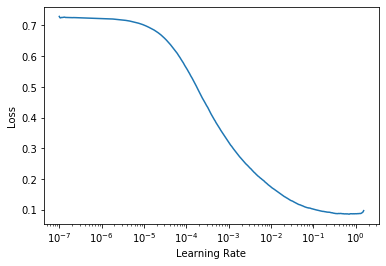

In [17]:
learn.lr_find(num_it=500)

In [ ]:
do_fit(learn, 10, 1e-2)
learn.save(f'runs/{name}-1')

## Submit

In [19]:
#export
class FlattenPred(Callback):
    def __init__(self): super().__init__()

    def after_pred(self):
        learn = self.learn
        learn.pred = learn.pred.view(-1, *learn.pred.shape[2:])

In [23]:
#export
def submit_predictions(learn, load_fn, sub_fn, message, dfunc=get_seutao_dls):
    df = Meta.df_tst
    learn.dls = dfunc(df, np_file_test, csv_file_test, bs=1, test=True)
    learn.load(load_fn)
    preds,targs = learn.get_preds()
    pred_csv = submission(df, preds, fn=sub_fn)
    api.competition_submit(f'{sub_fn}.csv', message, 'rsna-intracranial-hemorrhage-detection')

In [24]:
dls_test = get_seutao_dls_meta(Meta.df_tst, np_file_test, csv_file_test, bs=1, test=True)

loading features
Done loading features


In [22]:
dls_test.one_batch()[0][0].shape

torch.Size([1, 37, 2048])

In [ ]:
test(f'runs/{name}-1', f'subm/{name}', 'testing seutao features headonly try2')

In [40]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 13827415,
 'totalBytes': 27277209,
 'date': '2019-12-17T10:05:45.983Z',
 'description': 'testing seutao features headonly try2',
 'errorDescription': None,
 'fileName': 'seutao_feat_headonly.csv',
 'publicScore': '0.58344',
 'privateScore': '0.05386',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/13827415/13827415.raw'}

## Export

In [1]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_metadata.ipynb.
Converted 01_preprocess.ipynb.
Converted 01_preprocess_mean_std.ipynb.
Converted 02_train.ipynb.
Converted 02_train_01_save_features.ipynb.
Converted 03_train3d.ipynb.
Converted 04_trainfull3d_deprecated.ipynb.
Converted 04_trainfull3d_labels.ipynb.
Converted 04_trainfull3d_labels_01_partial3d.ipynb.
Converted 04_trainfull3d_labels_01_partial3d_old.ipynb.
Converted 04_trainfull3d_labels_02_full3d.ipynb.
Converted 04_trainfull3d_labels_02_full3d_old.ipynb.
Converted 04_trainfull3d_labels_03_MIL.ipynb.
Converted 05_train_adjacent.ipynb.
Converted 06_seutao_features.ipynb.
Converted Tabular_02_FeatureImportance.ipynb.
